脑电数据的Epoching处理   
点击上面"脑机接口社区"关注我们    
更多技术干货第一时间送达
  

## Epoch概念简介
  
从连续的脑电图信号中提取一些特定时间窗口的信号，这些时间窗口可以称作为epochs。  
由于EEG是连续收集的，要分析脑电事件相关的电位时，需要将信号"切分"成时间片段，  
这些时间片段被锁定到某个事件（例如刺激）中的时间片段。  
比如在EEGLAB分析中，EEGLAB将连续数据视为由一个较长的时期(long epoch)组成，  
而将数据切分后，它由多个较小的时期(small epoch)组成。  

举个例子  
假设我们有一个长度为60s的信号x，采样频率为1 Hz.  
脑电信号的矩阵表示为1x60矩阵，如果将信号划分成一些2s的信号，则将有30个peoch  
(信号中每2s就是一个epoch)  
关于Epoch的数据结构和创建方法可以查看  
Python-EEG工具库MNE中文教程(2)-MNE中数据结构Epoch及其创建方法  
关于Epoch的数据结构和一些用法可以查看  
Python-EEG工具库MNE中文教程(3)-MNE中数据结构Epoch及其用法简介  
关于Epoch的元数据(metadata)请看  
Python-EEG工具库MNE中文教程(14)-Epoch对象中的元数据(metadata)  
关于Epoch的数据可视化请看  
Python-EEG工具库MNE中文教程(15)-Epochs数据可视化  

## 这里介绍脑电数据的Epoching处理。

In [1]:
import os.path as op
import numpy as np
import mne
import matplotlib.pyplot as plt

In [4]:
# 在MNE中，epochs是指单个试验或一小段时间锁定的原始数据的集合。
# 首先，读入原始样本数据:

data_path = mne.datasets.sample.data_path()

fname = op.join(data_path, 'MEG', 'sample', 'sample_audvis_raw.fif')

raw = mne.io.read_raw_fif(fname)

# 设置EEG 平均参考
raw.set_eeg_reference('average', projection=True)

Opening raw data file C:\Users\Administrator\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Adding average EEG reference projection.
1 projection items deactivated


<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 166800 (277.7 sec), ~3.6 MB, data not loaded>

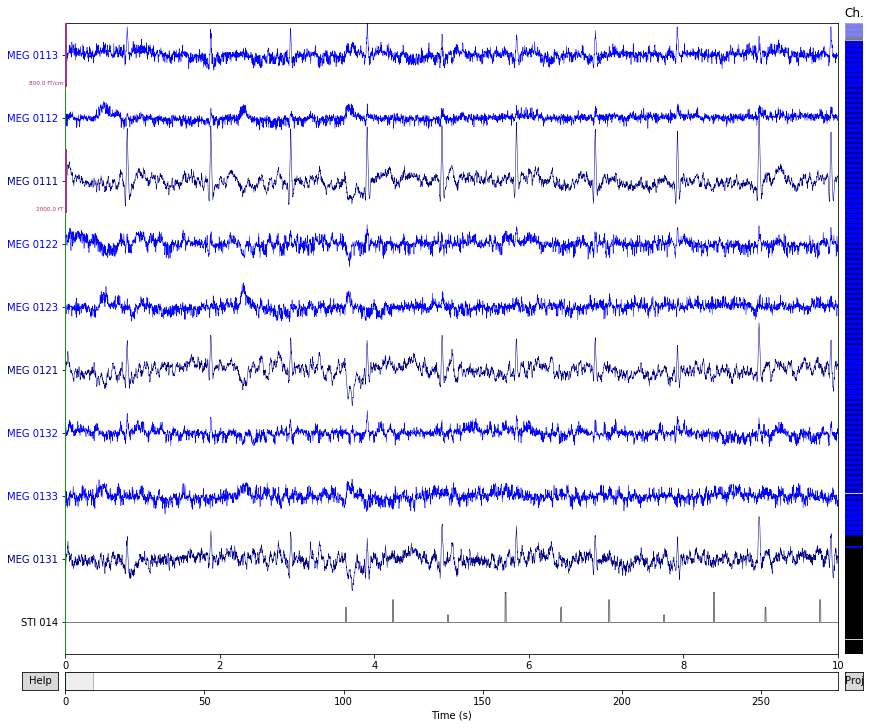

In [5]:
# 要创建时间锁定的epochs，首先需要一组包含有关时间信息的事件。
# 这里使用刺激通道来定义事件。


order = np.arange(raw.info['nchan'])

"""交换两个通道的绘图顺序，以将触发通道显示为第十个通道。"""

order[9] = 312
order[312] = 9  
raw.plot(n_channels=10, order=order, block=True)

plt.show()

In [8]:
# 注意底部的STI 014频道。
# 触发通道用于将所有事件合并到单个通道中。
# 从上图上可以看到在整个记录中有几个振幅不同的脉冲。
# 这些脉冲对应于在采集过程中呈现给受试者的不同刺激。
# 脉冲的值为1、2、3、4、5和32。
# 要从原始数据创建事件列表，MNE中只需调用一个专门用于此目的的函数。
# 由于事件列表只是一个numpy数组，所以也可以手动创建一个。
# 如果是从外部源(如单独的事件文件)创建事件，则应注意将事件与原始数据正确对齐。

events = mne.find_events(raw)

print('Found %s events, first five:' % len(events))

print(events[:5])

320 events found
Event IDs: [ 1  2  3  4  5 32]
Found 320 events, first five:
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


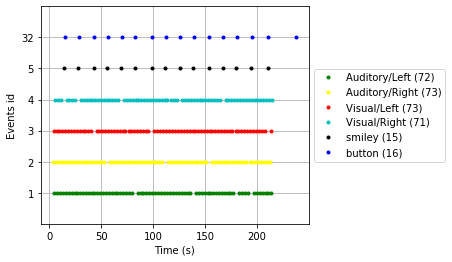

In [9]:
"""绘制事件以了解范例为图例指定颜色和event_id字典。"""

event_id = {'Auditory/Left': 1, 
            'Auditory/Right': 2,
            'Visual/Left': 3,
            'Visual/Right': 4,
            'smiley': 5, 
            'button': 32}
color = {1: 'green', 2: 'yellow', 3: 'red', 4: 'c', 5: 'black', 32: 'blue'}
mne.viz.plot_events(events,
                    raw.info['sfreq'], 
                    raw.first_samp,
                    color=color, 
                    event_id=event_id)
plt.show()

如上面所示，事件列表包含三列。    
第一列对应于样本编号，要将此转换为秒，可以将采样数除以使用的采样频率。    
第二列是在转换时保留给触发器通道的旧值，目前没有使用。    
第三列是触发ID(脉冲幅度)。  


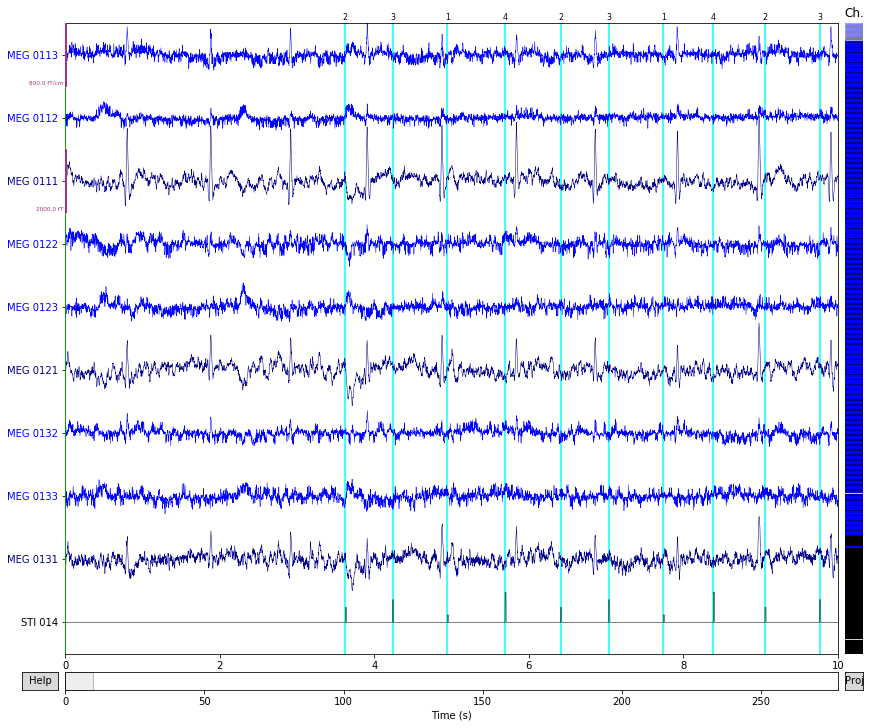

In [10]:
  
# 这里说明一下为什么这些样本看起来与绘制的数据不一致。
# 例如，第一个事件的样本编号为27977，应该转换为大约46.6秒(27977 / 600)。
# 但是查看脉冲时，可以在3.6秒时看到第一个脉冲。
# 这是因为Neuromag记录有一个first_samp属性，它表示系统启动和录制开始之间的偏移量。
# Neuromag记录数据的first_samp等于25800。
# 这意味着使用raw.plot看到的第一个样本的样本号25800。
# 一般来说，在使用时不需要担心这个偏移量，因为它在MNE函数中已经被考虑进去了，不过最好要注意这一点。
# 为了确认一下，我们将事件与原始数据一起绘制。
# 注意垂直线(事件)如何与STI 014上的脉冲很好地对齐。


raw.plot(events=events, n_channels=10, order=order)
plt.show()

在本文中，我们只对触发器1、2、3和4感兴趣。  
这些触发器对应于听觉和视觉刺激。  
这里的event_id可以是int、int列表或dict。  
使用dict可以将这些id分配给不同的类别。  
当使用int或列表时，这个信息就会丢失。  
首先，我们为mne.Epochs构造函数定义一些参数，  
tmin和tmax指的是与事件相关的偏移量,  
并使用epoch来封装事件前200毫秒到事件后500毫秒的数据。  

In [13]:
tmin, tmax = -0.2, 0.5
event_id = {'Auditory/Left': 1, 
            'Auditory/Right': 2, 
           'Visual/Left': 3, 
            'Visual/Right': 4}

经过上面步骤，构建了epochs所需的参数。  


为了得到一些有意义的结果，我们还希望将这些epochs作为基线。  
基线化计算基线期间的平均值并相应地调整数据。  
epochs构造函数默认使用从tmin到0.0秒的基线周期，  
作为元组的第一个元素的None指的是时间窗口的开始(本例中为-200 ms)  
 

这里定义了阈值来去除噪声。  
阈值被定义为epoch时间窗口内的峰到峰的值。  

定义为T/m表示梯度计，  
T表示磁强计，  
V表示EEG和EOG电极。  

In [14]:
baseline = (None, 0.0)

reject = {'mag': 4e-12, 'eog': 200e-6}
epochs = mne.Epochs(raw, events=events,
                    event_id=event_id, tmin=tmin,
                    tmax=tmax, baseline=baseline,
                    reject=reject, 
                   picks=('meg', 'eog'))
#   # 这里只包含 MEG 和 EOG289
#     matching events found
#     Applying baseline correction (mode: mean)
#     Not setting metadata
#     Created an SSP operator (subspace dimension = 3)
#     4 projection items activated
    
下面就绘制epochs查看结果。
顶部的数字是指ID号，从图中可以看到145个事件中有128个通过了rejection process。

epochs.plot(block=True)
plt.show()

SyntaxError: invalid character in identifier (<ipython-input-14-5930ca0c8f05>, line 1)

In [ ]:
通过绘制drop日志，来查看为什么剔除epoch(一般被伪影等污染的epoch数据需要被剔除)。
	• 
	• 
epochs.plot_drop_log()
plt.show()

In [ ]:
要获得诱发响应，只需执行epoch.average()。
它默认只包含数据通道。
为了便于举例，我们还使用pick来包含EOG通道。
	• 
	• 
	• 
picks = mne.pick_types(epochs.info, meg=True, eog=True)
evoked_left = epochs['Auditory/Left'].average(picks=picks)
evoked_right = epochs['Auditory/Right'].average(picks=picks)
注意，这里使用了前斜杠('/')来分隔实验条件的各个因素。
我们可以使用这些“标签”来选择例如所有左侧试验(包括视觉左侧和听觉右侧)。
	• 
	• 
	• 
	• 
	• 
epochs_left = epochs['Left']# ... or to select a very specific subset. 
This is the same as above:
evoked_left_again = epochs['Left/Auditory'].average(picks=picks)
下面绘制诱发响应
	• 
	• 
	• 
evoked_left.plot(time_unit='s')
evoked_right.plot(time_unit='s')
plt.show()